In [1]:
from astropy.io import fits

fits_file = fits.open('data.fits')

print(fits_file)

In [2]:
image_data = fits_file[0].data

print(image_data)

[[1696 1552 1632 ... 1504 1456 1504]
 [1552 1568 1584 ... 1632 1584 1568]
 [1696 1696 1568 ... 1488 1680 1408]
 ...
 [1584 1600 1616 ... 1664 1648 1728]
 [1648 1536 1600 ... 1552 1584 1664]
 [1488 1600 1600 ... 1568 1552 1632]]


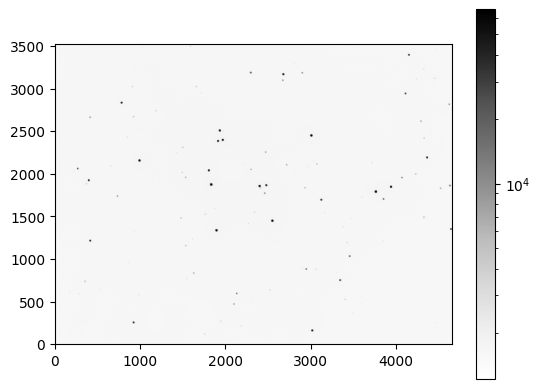

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure()
plt.imshow(image_data, origin='lower', norm=LogNorm(), cmap='Greys')
plt.colorbar()
plt.show()

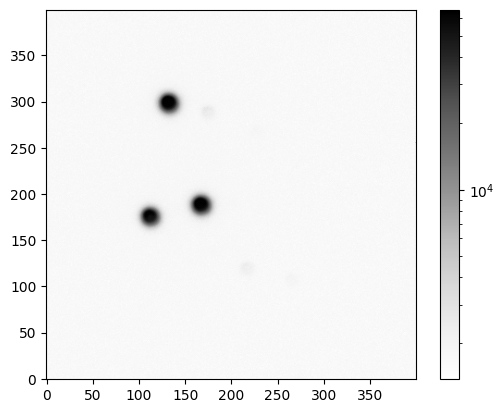

In [23]:
section1 = image_data[2200:2600, 1800:2200]

plt.figure()
plt.imshow(section1, origin='lower', norm=LogNorm(), cmap='Greys')
plt.colorbar()
plt.show()

In [24]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(section1, sigma=3.0)

print(mean, median, std)

1693.8765594306508 1696.0 81.37709445459026


In [25]:
from photutils.detection import DAOStarFinder

daofinder = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)

sources = daofinder(section1 - median)

for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'

sources.pprint(max_width=76)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak    flux  mag 
--- --------- --------- --------- ---------- ... ---- -------- ----- -----
  1    112.12    171.16      0.34       0.53 ... 0.00 41888.00 10.96 -2.60
  2    113.94    173.10      0.38       0.67 ... 0.00 45168.00 10.75 -2.58
  3    114.84    177.74      0.36      -0.29 ... 0.00 56320.00 21.26 -3.32
  4    109.14    177.85      0.35       0.94 ... 0.00 61808.00 30.38 -3.71
  5    112.46    178.56      0.32      -0.73 ... 0.00 61216.00 21.06 -3.31
  6    111.17    179.22      0.42       0.24 ... 0.00 56944.00 29.94 -3.69
  7    163.14    187.83      0.50      -0.78 ... 0.00 61824.00 23.58 -3.43
  8    169.47    188.47      0.28       0.66 ... 0.00 56896.00 15.43 -2.97
  9    134.00    297.34      0.31       0.65 ... 0.00 56288.00 17.10 -3.08
 10    135.91    298.69      0.31       0.13 ... 0.00 55488.00 22.90 -3.40
 11    130.52    302.52      0.43       0.85 ... 0.00 60720.00 39.66 -4.00


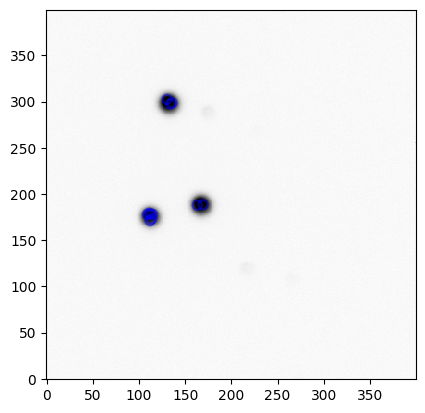

In [26]:
import numpy as np
from photutils.aperture import CircularAperture, ApertureStats

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
aperture = CircularAperture(positions, r=5.0)

plt.imshow(section1, origin='lower', cmap='Greys', norm=LogNorm(), interpolation='nearest')

aperture.plot(color='blue', lw=1.5, alpha=0.5)

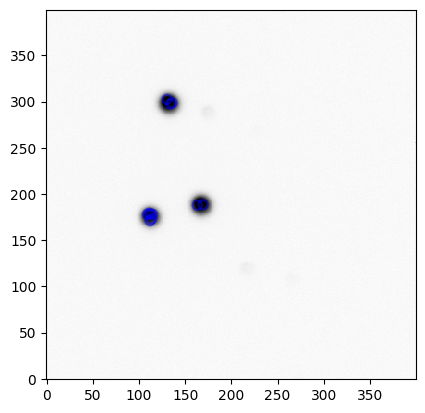

In [28]:
mask = np.zeros(section1.shape, dtype=bool)

mask[260:320, 40:80] = True
mask[230:350, 170:240] = True
mask[260:340, 240:320] = True
mask[250:330, 420:470] = True

sources = daofinder(section1 - median, mask=mask)
xpix = sources['xcentroid']
ypix = sources['ycentroid']

positions = np.transpose((xpix, ypix))
aperture = CircularAperture(positions, r=5.0)

plt.imshow(section1, origin='lower', cmap='Greys', norm=LogNorm(), interpolation='nearest')

aperture.plot(color='blue', lw=1.5, alpha=0.5)

In [29]:
print(aperture)

Aperture: CircularAperture
positions: [[112.119722  , 171.15921251],
            [113.94041378, 173.09778278],
            [114.84169644, 177.74428718],
            [109.14069239, 177.84581097],
            [112.45838396, 178.55791019],
            [111.16859895, 179.21579238],
            [163.14189107, 187.83268641],
            [169.47255895, 188.47232994],
            [133.99937708, 297.34487762],
            [135.90911839, 298.68580933],
            [130.52011443, 302.52183201]]
r: 5.0


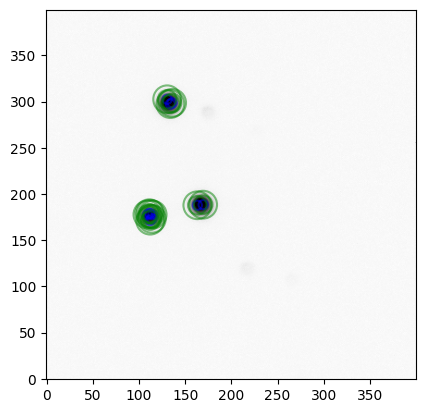

In [30]:
from photutils.aperture import CircularAnnulus, aperture_photometry, ApertureStats

annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

plt.figure()
plt.imshow(section1, origin='lower', cmap='Greys', norm=LogNorm())

aperture.plot(color='blue', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='green', lw=1.5, alpha=0.5)

plt.show()

In [32]:
aperstats = ApertureStats(section1, annulus_aperture)
bkg_mean = aperstats.mean
aperture_area = aperture.area_overlap(section1)
total_bkg = bkg_mean * aperture_area

star_data = aperture_photometry(section1, aperture)

star_data['total_bkg'] = total_bkg

for col in star_data.columns:
    star_data[col].info.format = '%.8g'

star_data.pprint()

 id  xcenter   ycenter  aperture_sum total_bkg
       pix       pix                          
--- --------- --------- ------------ ---------
  1 112.11972 171.15921    3184435.1 650067.28
  2 113.94041 173.09778    3607556.7 509247.38
  3  114.8417 177.74429      3868705 555151.48
  4 109.14069 177.84581    4172879.7 568991.87
  5 112.45838 178.55791    4238540.7  510856.2
  6  111.1686 179.21579    4109284.1 575552.56
  7 163.14189 187.83269    4443718.5 718920.79
  8 169.47256 188.47233    4656731.7 574251.56
  9 133.99938 297.34488      4754915 561694.33
 10 135.90912 298.68581    4395980.5 747650.84
 11 130.52011 302.52183      4335576 791914.99


In [33]:
print(repr(fits_file[0].header))

SIMPLE  =                    T / C# FITS                                        
BITPIX  =                   16 /                                                
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                 4656 /                                                
NAXIS2  =                 3522 /                                                
BZERO   =                32768 /                                                
EXTEND  =                    T / Extensions are permitted                       
IMAGETYP= 'LIGHT'              / Type of exposure                               
EXPOSURE=                120.0 / [s] Exposure duration                          
EXPTIME =                120.0 / [s] Exposure duration                          
DATE-LOC= '2024-05-02T21:00:51.332' / Time of observation (local)               
DATE-OBS= '2024-05-02T12:00:51.332' / Time of observation (UTC)                 
XBINNING=                   

In [52]:
from acstools import acszpt
from astropy.table.table import QTable

hdr = fits_file[0].header
date = hdr['DATE-OBS'].split('T')[0]
# instrument = hdr['INSTRUME'] = QHY163M  이거 뭐지 안되는데 
instrument = 'WFC'
# filter = hdr['FILTER'].split('')
filter = 'F814W'

q = acszpt.Query(date=date, detector=instrument)
zpt_table = q.fetch()
q_filter = acszpt.Query(date=date, detector=instrument, filt=filter)
filter_zpt: QTable = q_filter.fetch()

# print(zpt_table)
print(filter_zpt.columns)
print(filter_zpt)

<TableColumns names=('Filter','PHOTLAM','PHOTFLAM','STmag','VEGAmag','ABmag')>
odict_values([<Column name='Filter' dtype='bytes5' unit='' length=1>
F814W, <Quantity [8045.5] Angstrom>, <Quantity [7.1251e-20] erg / (Angstrom electron cm2)>, <Magnitude [26.768] mag(ST)>, <Quantity [25.501] mag>, <Magnitude [25.932] mag(AB)>])


In [103]:
zeropoint = float(filter_zpt[0].get('ABmag').__repr__().split()[1])
print(type(zeropoint), zeropoint)
extime = hdr['EXPTIME']

import math

magnitudes = []
for line in star_data:
    magnitudes.append(zeropoint - (2.5 * math.log10(abs(line[3] - line[4]) / extime)))

star_data['magnitudes'] = magnitudes
star_data.pprint(max_lines=-1, max_width=-1)

<class 'float'> 25.932
 id  xcenter   ycenter  aperture_sum total_bkg     magnitudes    
       pix       pix                                             
--- --------- --------- ------------ --------- ------------------
  1 112.11972 171.15921    3184435.1 650067.28  15.12027900367378
  2 113.94041 173.09778    3607556.7 509247.38 14.902141176687262
  3  114.8417 177.74429      3868705 555151.48 14.829218147345841
  4 109.14069 177.84581    4172879.7 568991.87  14.73802494719584
  5 112.45838 178.55791    4238540.7  510856.2  14.70135525902657
  6  111.1686 179.21579    4109284.1 575552.56 14.759369229576228
  7 163.14189 187.83269    4443718.5 718920.79 14.702196382305893
  8 169.47256 188.47233    4656731.7 574251.56 14.602642903397879
  9 133.99938 297.34488      4754915 561694.33 14.573583809711192
 10 135.90912 298.68581    4395980.5 747650.84 14.724717945900322
 11 130.52011 302.52183      4335576 791914.99 14.756322697076532
